##  <b> <span style='color:#16C2D5'>|</span> Projeye Başlarken GPU' nun Ayarlanması </b>

In [1]:
!nvidia-smi

Wed Oct 18 22:32:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


##  <b> <span style='color:#16C2D5'>|</span> Videonun Yüklenmesi </b>

In [3]:
SOURCE_VIDEO_PATH = f"/kaggle/input/otoyol-video/otoyol1.mp4"

##  <b> <span style='color:#16C2D5'>|</span> YOLO'nun Ultralytics İle Eklenmesi </b>

In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5016.7/8062.4 GB disk)


##  <b> <span style='color:#16C2D5'>|</span> ByteTrack' ın GitHub Üzerinden İndirilmesi </b>

In [5]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack


!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##  <b> <span style='color:#16C2D5'>|</span> SuperVision Kütüphanesinin Yüklenmesi </b>

In [7]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [8]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

##  <b> <span style='color:#16C2D5'>|</span> Nesne Tanıma İşleminin Yapılması </b>

In [9]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

##  <b> <span style='color:#16C2D5'>|</span> Modelin Ön Eğitimden Geçirilmesi </b>

In [10]:
# settings
MODEL = "yolov8x.pt"

In [11]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 172MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


##  <b> <span style='color:#16C2D5'>|</span> Video Üzerinde Tek Karenin Seçilmesi Ve Tahmin İşlemi </b>

In [12]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 9 cars, 1 truck, 1 traffic light, 81.7ms
Speed: 19.0ms preprocess, 81.7ms inference, 17.8ms postprocess per image at shape (1, 3, 384, 640)


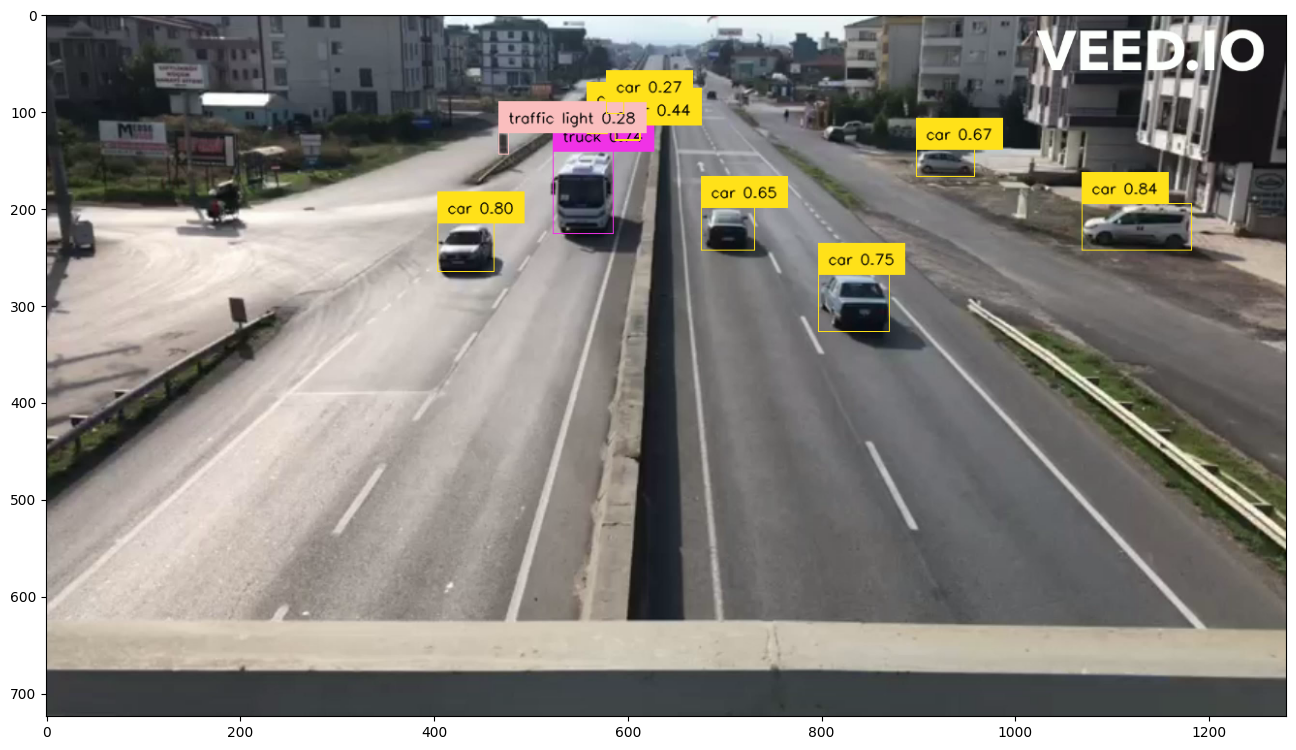

In [13]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

##  <b> <span style='color:#16C2D5'>|</span> Video Üzerinde Çizgi Seçilmesi </b>

In [14]:
# settings
LINE_START = Point(205, 300)
LINE_END = Point(1000, 300)

TARGET_VIDEO_PATH = f"{HOME}/otoyol-sonuc.mp4"

In [15]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=724, fps=30, total_frames=955)

##  <b> <span style='color:#16C2D5'>|</span> Videoda Nesne Tanıma Ve Saydırma İşleminin Yapılması  </b>

In [16]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=0.5)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/955 [00:00<?, ?it/s]


0: 384x640 9 cars, 1 truck, 1 traffic light, 42.8ms
Speed: 2.2ms preprocess, 42.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 1 traffic light, 42.7ms
Speed: 2.4ms preprocess, 42.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 1 traffic light, 40.8ms
Speed: 1.8ms preprocess, 40.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 truck, 1 traffic light, 40.1ms
Speed: 1.6ms preprocess, 40.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 traffic light, 37.5ms
Speed: 2.2ms preprocess, 37.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bus, 1 traffic light, 36.1ms
Speed: 1.6ms preprocess, 36.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 truck, 1 traffic light, 35.5ms
Speed: 1.8ms preprocess, 35.5ms infer